# <span style='color:aliceblue'><center style='background:#000000 border-radius:0px 25px;padding:25px'> 🦋🌸Part 1. Benchmarking and Profiling🌻🌈</center></span>

### 1. Read the sections“Introducing the Julia Set”and “Calculating the Full Julia Set”on Chapter  2.  Profiling  to  Find  Bottlenecksfrom  the book: M.  Gorelick  &  I.  Ozsvald (2020). High Performance Python. Practical Performant Programming for Humans.Second  Edition.  United  States  of  America:  O’Reilly  Media,  Inc.Implement  the chapter functions(Example2-1, 2-2, 2-3 and 2-4)on Python in order to calculate the Julia Set. Make the representation for the false gray and pure gray scale.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def iterate_julia(z, c, maxiter):
    """Iterate z = z^2 + c and check for escape condition."""
    for iteration in range(maxiter):
        if abs(z) >= 2.0:
            return iteration  # The point escapes
        z = z * z + c
    return maxiter  # The point doesn't escape

# Example 1: Top-left corner of the plot
z_top_left = -1.8 - 1.8j
print(abs(z_top_left))
c = -0.62772 - 0.42193j  # Constant c for the Julia set
maxiter = 300  # Maximum number of iterations
escape_iterations_top_left = iterate_julia(z_top_left, c, maxiter)
print(f"Top-left corner escape iterations: {escape_iterations_top_left}")

# Example 2: Center of the plot
z_center = 0 + 0j
for n in range(9):  # Trying a few iterations for demonstration
    z_center = z_center * z_center + c
    print(f"{n}: z={z_center:.5f}, abs(z)={abs(z_center):.3f}, c={c:.5f}")

# For a thorough demonstration, let's calculate how many iterations it takes for the center point to escape
# or confirm it stays bounded within the maxiter limit.
z_center = 0 + 0j
escape_iterations_center = iterate_julia(z_center, c, maxiter)
print(f"Center point escape iterations: {escape_iterations_center}")

2.545584412271571
Top-left corner escape iterations: 0
0: z=-0.62772-0.42193j, abs(z)=0.756, c=-0.62772-0.42193j
1: z=-0.41171+0.10778j, abs(z)=0.426, c=-0.62772-0.42193j
2: z=-0.46983-0.51068j, abs(z)=0.694, c=-0.62772-0.42193j
3: z=-0.66777+0.05793j, abs(z)=0.670, c=-0.62772-0.42193j
4: z=-0.18516-0.49930j, abs(z)=0.533, c=-0.62772-0.42193j
5: z=-0.84274-0.23703j, abs(z)=0.875, c=-0.62772-0.42193j
6: z=0.02630-0.02242j, abs(z)=0.035, c=-0.62772-0.42193j
7: z=-0.62753-0.42311j, abs(z)=0.757, c=-0.62772-0.42193j
8: z=-0.41295+0.10910j, abs(z)=0.427, c=-0.62772-0.42193j
Center point escape iterations: 300


In [ ]:
"""Julia set generator without optional PIL-based image drawing"""
import time
from PIL import Image
import array

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193


def show_greyscale(output_raw, width, height, max_iterations):
    """Convert list to array, show using PIL"""
    # convert our output to PIL-compatible input
    # scale to [0...255]
    max_iterations = float(max(output_raw))
    print(max_iterations)
    scale_factor = float(max_iterations)
    scaled = [int(o / scale_factor * 255) for o in output_raw]
    output = array.array('B', scaled)  # array of unsigned ints
    # display with PIL
    im = Image.new("L", (width, width))
    # EXPLAIN RAW L 0 -1
    im.frombytes(output.tobytes(), "raw", "L", 0, -1)
    im.show()


def show_false_greyscale(output_raw, width, height, max_iterations):
    """Convert list to array, show using PIL"""
    # convert our output to PIL-compatible input
    assert width * height == len(output_raw)  # sanity check our 1D array and desired 2D form
    # rescale output_raw to be in the inclusive range [0..255]
    max_value = float(max(output_raw))
    output_raw_limited = [int(float(o) / max_value * 255) for o in output_raw]
    # create a slightly fancy colour map that shows colour changes with
    # increased contrast (thanks to John Montgomery)
    output_rgb = ((o + (256 * o) + (256 ** 2) * o) * 16 for o in output_raw_limited)  # fancier
    output_rgb = array.array('I', output_rgb)  # array of unsigned ints (size is platform specific)
    # display with PIL/pillow
    im = Image.new("RGB", (width, height))
    # EXPLAIN RGBX L 0 -1
    im.frombytes(output_rgb.tobytes(), "raw", "RGBX", 0, -1)
    im.show()


def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output


def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex co-ordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # set width and height to the generated pixel counts, rather than the
    # pre-rounding desired width and height
    width = len(x)
    height = len(y)
    # build a list of co-ordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # this sum is expected for 1000^2 grid with 300 iterations

    if draw_output:
        #show_false_greyscale(output, width, height, max_iterations)
        show_greyscale(output, width, height, max_iterations)


if __name__ == "__main__":
    # Calculate the Julia set using a pure Python solution with
    # reasonable defaults for a laptop
    # set draw_output to True to use PIL to draw an image
    calc_pure_python(draw_output=True, desired_width=1000, max_iterations=300)

Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 9.820289611816406 seconds
300.0


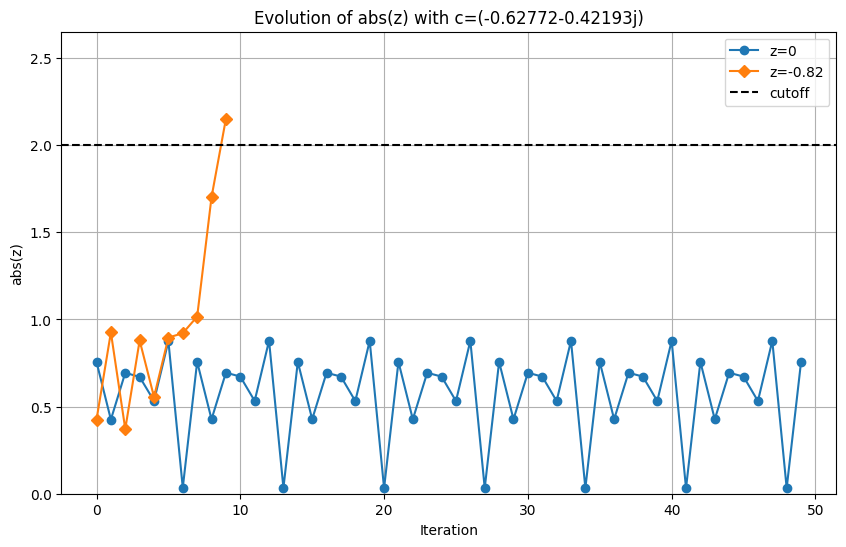

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_julia_iterations(c, z_values, maxiter):
    plt.figure(figsize=(10, 6))

    # Iterate over each initial z value
    for z_init in z_values:
        z = z_init
        abs_values = []
        for i in range(maxiter):
            z = z**2 + c
            abs_values.append(abs(z))
            if abs(z) > 2:
                break

        # Plot the absolute values
        plt.plot(abs_values, label=f'z={z_init}', marker='o' if z_init == 0 else 'D')

    plt.axhline(y=2, color='k', linestyle='--', label='cutoff')
    plt.title('Evolution of abs(z) with c={}'.format(c))
    plt.xlabel('Iteration')
    plt.ylabel('abs(z)')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, max(abs_values) + 0.5)  # adjust the y-axis limit to show all points clearly
    plt.show()

# Constants
c = complex(-0.62772, -0.42193)
maxiter = 50
z_values = [0, -0.82]

# Generate the plot
plot_julia_iterations(c, z_values, maxiter)

*Figure 2-2. Two coordinate examples evolving for the Julia set*

### 2. Define a new function, timefn, which takes a function as an argument: the inner function, measure_time, takes *args (a variable number of positional arguments) and **kwargs (a variable number of key/value arguments) and passes them through to fn for execution. Decorate calculate_z_serial_purepythonwith @timefn to profile it. Implement Example 2-5 and adapt your current source code.

In [ ]:
import time
from functools import wraps

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print(f"@timefn: {fn.__name__} took {t2 - t1} seconds")
        return result
    return measure_time

@timefn
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y2 - y1) / desired_width
    x = [x1 + i * x_step for i in range(desired_width)]
    y = [y1 + i * y_step for i in range(desired_width)]
    zs = [complex(x[i % desired_width], y[i // desired_width]) for i in range(desired_width ** 2)]
    cs = [complex(c_real, c_imag) for i in range(desired_width ** 2)]

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    # Verify the result is as expected
    assert sum(output) == 33219980  # this sum is expected for a 1000^2 grid with 300 iterations

# Run the Julia set calculation with the corrected function
calc_pure_python(draw_output=True, desired_width=1000, max_iterations=300)

Length of x: 1000
Total elements: 1000000
@timefn: calculate_z_serial_purepython took 16.060999631881714 seconds
calculate_z_serial_purepython took 16.061999082565308 seconds


### 3. Use the timeit modeule to get a coarse measurement of the execution speed of the CPU-bound  function. Runs  10  loops  with  5  repetitions.  Show  how  to do  the measurement on the command lineand on a Jupyter Notebook.


### Jupyter Notebook:

In [12]:
import time
from functools import wraps

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

def timefn(fn):
    def measure_time(*args, **kwargs):
        times = []
        for _ in range(5):  # number of loops
            t1 = time.time()
            result = fn(*args, **kwargs)
            t2 = time.time()
            times.append(t2 - t1)
        best_time = min(times)
        print(f"Best of 5: {best_time} sec per loop")
        return result
    return measure_time

@timefn
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y2 - y1) / desired_width
    x = [x1 + i * x_step for i in range(desired_width)]
    y = [y1 + i * y_step for i in range(desired_width)]
    zs = [complex(x[i % desired_width], y[i // desired_width]) for i in range(desired_width ** 2)]
    cs = [complex(c_real, c_imag) for i in range(desired_width ** 2)]

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    # Verify the result is as expected
    assert sum(output) == 33219980  # this sum is expected for a 1000^2 grid with 300 iterations

# Run the Julia set calculation with the corrected function
calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)

Length of x: 1000
Total elements: 1000000
Best of 5: 13.934248685836792 sec per loop
measure_time took 74.90498042106628 seconds


### Command line

In [13]:
%timeit calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)

Length of x: 1000
Total elements: 1000000
Best of 5: 14.931426763534546 sec per loop
measure_time took 81.14974355697632 seconds
Length of x: 1000
Total elements: 1000000
Best of 5: 12.213003635406494 sec per loop
measure_time took 72.77231550216675 seconds
Length of x: 1000
Total elements: 1000000
Best of 5: 12.806839227676392 sec per loop
measure_time took 71.97101616859436 seconds
Length of x: 1000
Total elements: 1000000
Best of 5: 12.018502235412598 sec per loop
measure_time took 64.46442151069641 seconds
Length of x: 1000
Total elements: 1000000
Best of 5: 13.302000522613525 sec per loop
measure_time took 68.27173662185669 seconds
Length of x: 1000
Total elements: 1000000
Best of 5: 11.110952615737915 sec per loop
measure_time took 60.243282079696655 seconds
Length of x: 1000
Total elements: 1000000
Best of 5: 10.749995470046997 sec per loop
measure_time took 57.45467925071716 seconds
Length of x: 1000
Total elements: 1000000
Best of 5: 12.98752474784851 sec per loop
measure_time

### 4.Use the cProfile module to profilethe source code (.py). Sort the results by the time spent inside each function. This will give a view into the slowest parts. Analyze the output and make a syntesis of the findings. Show how to use the cProfile module on the command line and on a Jupyter Notebook.

### Jupyter Notebook

In [1]:
import cProfile
import time

# Attempt to import the profile decorator from line_profiler if installed
try:
    from line_profiler import profile
except ImportError:
    def profile(func):
        """ Dummy decorator in case line_profiler is not installed. """
        return func

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

@profile
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

@profile
def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y2 - y1) / desired_width
    x = [x1 + i * x_step for i in range(desired_width)]
    y = [y1 + i * y_step for i in range(desired_width)]
    zs = [complex(x[i % desired_width], y[i // desired_width]) for i in range(desired_width ** 2)]
    cs = [complex(c_real, c_imag) for i in range(desired_width ** 2)]

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # this sum is expected for a 1000^2 grid with 300 iterations

if __name__ == "__main__":
    cProfile.run('calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)', 'profile_stats')


Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 22.233978271484375 seconds


In [2]:
import pstats

p = pstats.Stats('profile_stats')
p.sort_stats('cumulative').print_stats(10)  # Adjust this number to display more or fewer lines

Fri Mar 29 18:07:03 2024    profile_stats

         34220127 function calls in 22.908 seconds

   Ordered by: cumulative time
   List reduced from 29 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   22.908   22.908 {built-in method builtins.exec}
        1    0.031    0.031   22.908   22.908 <string>:1(<module>)
        1    0.000    0.000   22.877   22.877 C:\Users\Priscila\AppData\Local\Temp\ipykernel_17984\2613920211.py:30(calc_pure_python)
        1   15.429   15.429   22.221   22.221 C:\Users\Priscila\AppData\Local\Temp\ipykernel_17984\2613920211.py:16(calculate_z_serial_purepython)
 34219980    6.792    0.000    6.792    0.000 {built-in method builtins.abs}
        1    0.389    0.389    0.389    0.389 C:\Users\Priscila\AppData\Local\Temp\ipykernel_17984\2613920211.py:37(<listcomp>)
        1    0.254    0.254    0.254    0.254 C:\Users\Priscila\AppData\Local\Temp\ipykernel_17984\2613920211.py:38(

### Command Line

The file to run the same code on the command line is called cprofile_part_1_4.py.

In [ ]:
python cprofile_part_1_4.py

In [ ]:
python -m cProfile -s cumulative cprofile_part_1_4.py

In [ ]:
python -c "import pstats; p = pstats.Stats('profile_stats'); p.sort_stats('cumulative').print_stats(10)"

### 5. Use snakeviz to get a high-level understanding of thecPrifile statistics file.Analyze the output and make a syntesis of the findings.

In [3]:
!pip install snakeviz

In [ ]:
if __name__ == "__main__":
    cProfile.run('calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)', 'profile_stats')

Length of x: 1000
Total elements: 1000000


In [ ]:
!snakeviz 'profile_stats'

### 6. Use  the  line_profiler  and  kernprof  file  to  profile  line-by-line  the  function calculate_z_serial_purepython. Analyze  the  output  and  make  a  syntesis  of  the findings.

In [1]:
!pip install line_profiler

In [2]:
%load_ext line_profiler

In [3]:
import time

# Attempt to import the profile decorator from line_profiler if installed
try:
    from line_profiler import profile
except ImportError:
    def profile(func):
        """ Dummy decorator in case line_profiler is not installed. """
        return func

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

@profile
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

@profile
def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y2 - y1) / desired_width
    x = [x1 + i * x_step for i in range(desired_width)]
    y = [y1 + i * y_step for i in range(desired_width)]
    zs = [complex(x[i % desired_width], y[i // desired_width]) for i in range(desired_width ** 2)]
    cs = [complex(c_real, c_imag) for i in range(desired_width ** 2)]

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # this sum is expected for a 1000^2 grid with 300 iterations

# Calculate the Julia set using a pure Python solution with
# reasonable defaults for a laptop
calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)


Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 10.623979330062866 seconds


In [4]:
%lprun -f calculate_z_serial_purepython calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)

Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 125.2259042263031 seconds


Timer unit: 1e-07 s

Total time: 81.9963 s
File: C:\Users\Priscila\AppData\Local\Temp\ipykernel_19216\2939688537.py
Function: calculate_z_serial_purepython at line 15

Line #      Hits         Time  Per Hit   % Time  Line Contents
    15                                           @profile
    16                                           def calculate_z_serial_purepython(maxiter, zs, cs):
    17                                               """Calculate output list using Julia update rule"""
    18         1      59527.0  59527.0      0.0      output = [0] * len(zs)
    19   1000001    5552058.0      5.6      0.7      for i in range(len(zs)):
    20   1000000    5061430.0      5.1      0.6          n = 0
    21   1000000    6210186.0      6.2      0.8          z = zs[i]
    22   1000000    5880454.0      5.9      0.7          c = cs[i]
    23  34219980  350695859.0     10.2     42.8          while abs(z) < 2 and n < maxiter:
    24  33219980  245711516.0      7.4     30.0              z 

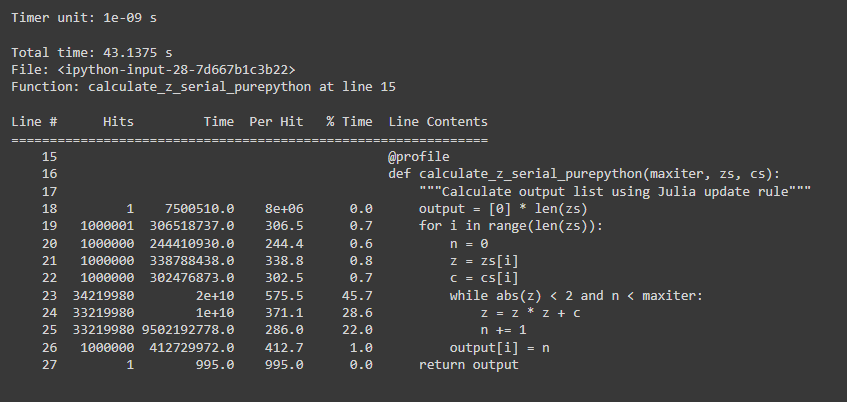

### 7. Use the memory_profiler to diagnose memory usage. Analyze the output and make a syntesis of the findings.

In [1]:
!pip install memory_profiler
!pip install psutil

In [3]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [4]:
%%memit
# Import necessary libraries
import time

# Define your area of complex space and other parameters
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs), build Julia set"""
    x_step = (x2 - x1) / desired_width
    y_step = (y2 - y1) / desired_width
    x = [x1 + i * x_step for i in range(desired_width)]
    y = [y1 + i * y_step for i in range(desired_width)]
    zs = [complex(x[i % desired_width], y[i // desired_width]) for i in range(desired_width ** 2)]
    cs = [complex(c_real, c_imag) for i in range(desired_width ** 2)]

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # Expected sum for a 1000^2 grid with 300 iterations

# Execute the function with the given parameters
calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)


Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 12.248991250991821 seconds
peak memory: 159.28 MiB, increment: 88.51 MiB
